In [1]:
# Importing needed libs for API calls
import requests
import json
import io

# Pandas / NumPy / Sklearn
import pandas as pd
import numpy as np
import sklearn
import xgboost
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Database connection
import sqlalchemy

# Viz matplotlib / seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Company-proprietary libs
import os
#import ******dbconnector as ***
#from ****** import *****
#from ***** import *****

# Progress bars and time
from tqdm.notebook import trange, tqdm
from time import sleep

# Turn off warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import warnings
warnings.filterwarnings('ignore')

# Scipy
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from kmodes import kprototypes

## Connect to Redshift

In [2]:
uid = "*****"
pwd = "*****"
cluster = "*****"
db = "*****"

conn_str_rs = "postgresql://" + uid + ":" + pwd + "@" + cluster + ":5439/" + db
engine_rs = sqlalchemy.create_engine(conn_str_rs)

In [3]:
# Bring Data from Redshift
query = ''' SELECT
                Product_Id,
                MAX(prod_cost_bin) AS prod_cost_bin,
                MAX(web_part) AS web_part,
                MAX(ppap) AS ppap,
                MAX(group_package) AS group_package,
                MAX(price_group) AS price_group,
                MAX(price_leader) AS price_leader,
                -----------------
                AVG(price_unit) AS avg_pu,
                AVG(cost_unit) AS avg_cu,
                AVG(quantity) AS avg_quantity,
                AVG(normalized_variable) AS avg_nv,
                AVG(list_price_product) AS avg_list,
                AVG(forward_cogs) AS forward_cogs,
                MAX(product_level_1) AS product_level_1,
                MAX(product_level_2) AS product_level_2,
                MAX(product_level_3) AS product_level_3,
                MAX(product_level_4) AS product_level_4,
                MAX(division) AS division,
                MAX(pricestrategy) AS price_strategy                
            FROM "SM_TRANSACTION_0001"
            WHERE   filter_code = 0 --AND product_level_4 = 'PJAL'
            GROUP BY Product_Id
        '''

%time df = pd.read_sql(query, engine_rs)
df.head(1000)

Wall time: 2.38 s


,product_id,prod_cost_bin,web_part,ppap,group_package,price_group,price_leader,avg_pu,avg_cu,avg_quantity,avg_nv,avg_list,forward_cogs,product_level_1,product_level_2,product_level_3,product_level_4,division,price_strategy
0,LM385BD-1.2G,3_Low,LM385B,N,SOIC-8,LM385B,LM385BD-2.5R2G,0.334514,0.080567,73.625000,0.651439,0.513500,0.072900,AMG,PJ - MATURE POWER AND TIMING,PJN - MOSAIC 3 MIXED SIGNAL,PJNA,AMG - PMD,TAILORED
1,FDMS86520,2_Medium,FDMS86520,N,PQFN-WIRED,FDMS86520,FDMS86520,0.489731,0.080563,1743.942761,0.569819,0.859928,0.075175,PSG,PA - MED/HIGH VOLTAGE MOSFETS,PAC - HIGH VOLTAGE EPI COLLECTR,PACC,PSG - MPD,TAILORED
2,NCP3064BMNTXG,2_Medium,NCP3064,N,DFN,NCP3064,NCP3064BDR2G,0.353271,0.189126,939.794521,0.478317,0.737425,0.190573,AMG,PN - PMIC AND POL,PN3 - DCDC SWITCHERS,PN3D,AMG - PMD,TAILORED
3,BC846BWT1G,4_VLow,BC846BW,N,SC-70-CPR,BC846BW,BC846BWT1G,0.011601,0.003400,31857.250206,0.573830,0.020366,0.003547,PSG,PD - SMALL SIGNAL PRODUCTS,PDQ - SMALL SIG GEN PURP,PDQB,PSG - MPD,TAILORED
4,NCP81071ADR2G,2_Medium,NCP81071,N,SOIC-8,NCP81071,NCP81071BDR2G,0.404314,0.063179,3235.807143,0.510796,0.792974,0.063200,AMG,PN - PMIC AND POL,PN2 - P2A DCDC CONTROLLERS,PN2A,AMG - PMD,TAILORED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,SZMMSZ4679T1G,4_VLow,MMSZ4,Y,SOD-123-CPR,MMSZ4,MMSZ4707T1G,0.017984,0.004894,18632.098224,0.581079,0.030938,0.004877,PSG,PE - PROTECTION,PEA - ZENER ALLOY,PEAF,PSG - MPD,TAILORED
996,FDMA2002NZ,3_Low,FDMA2002NZ,N,UQFN,FDMA2002NZ,FDMA2002NZ,0.224461,0.057413,41567.288462,0.652882,0.343844,0.047784,PSG,PM - LOW VOLTAGE FETS,PMQ - SMALL SIGNAL MOSFET,PMQA,PSG - MPD,TAILORED
997,MT9V034C12STM-TP,1_High,MT9V034,N,CLCC-PLCC,MT9V034,MT9V034C12STM-DR,9.807060,2.643050,375.821656,0.585779,16.741900,3.026619,ISG,BA - ISG INDUSTRIAL CONSUMER,BAX - ICSD CONSR-INDUSTR,BAXA,ISG - ICS,EXIT
998,MC74HCT365ADTR2G,3_Low,MC74HCT365A,N,TSSOP-14-16,MC74HCT365A,MC74HCT365ADR2G,0.240137,0.046729,614.065476,1.110184,0.216943,0.038500,AMG,PK - MOS LOGIC,PKC - HIGH SPEED LOGIC,PKCA,AMG - ICD,FIXED


## Data Preparation & Clustering

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17688 entries, 0 to 17687
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       17688 non-null  object 
 1   prod_cost_bin    17688 non-null  object 
 2   web_part         17688 non-null  object 
 3   ppap             17688 non-null  object 
 4   group_package    17688 non-null  object 
 5   price_group      17688 non-null  object 
 6   price_leader     17688 non-null  object 
 7   avg_pu           17688 non-null  float64
 8   avg_cu           17688 non-null  float64
 9   avg_quantity     17688 non-null  float64
 10  avg_nv           17688 non-null  float64
 11  avg_list         17688 non-null  float64
 12  forward_cogs     17688 non-null  float64
 13  product_level_1  17688 non-null  object 
 14  product_level_2  17688 non-null  object 
 15  product_level_3  17688 non-null  object 
 16  product_level_4  17688 non-null  object 
 17  division    

In [5]:
# Encode categorical features
le = LabelEncoder()
df['prod_cost_bin']   = le.fit_transform(df['prod_cost_bin'])
df['web_part']        = le.fit_transform(df['web_part'])
df['ppap']            = le.fit_transform(df['ppap'])
df['group_package']   = le.fit_transform(df['group_package'])
df['price_group']     = le.fit_transform(df['price_group'])
df['price_leader']    = le.fit_transform(df['price_leader'])
df['product_level_1'] = le.fit_transform(df['product_level_1'])
df['product_level_2'] = le.fit_transform(df['product_level_2'])
df['product_level_3'] = le.fit_transform(df['product_level_3'])
df['product_level_4'] = le.fit_transform(df['product_level_4'])
df['division']        = le.fit_transform(df['division'])
df['price_strategy']  = le.fit_transform(df['price_strategy'])

In [6]:
# Standardize numerical features
scaler = StandardScaler()
df[['avg_pu', 'avg_cu', 'avg_quantity', 'avg_nv', 'avg_list', 'forward_cogs']] = scaler.fit_transform(df[['avg_pu', 'avg_cu', 'avg_quantity', 'avg_nv', 'avg_list', 'forward_cogs']])

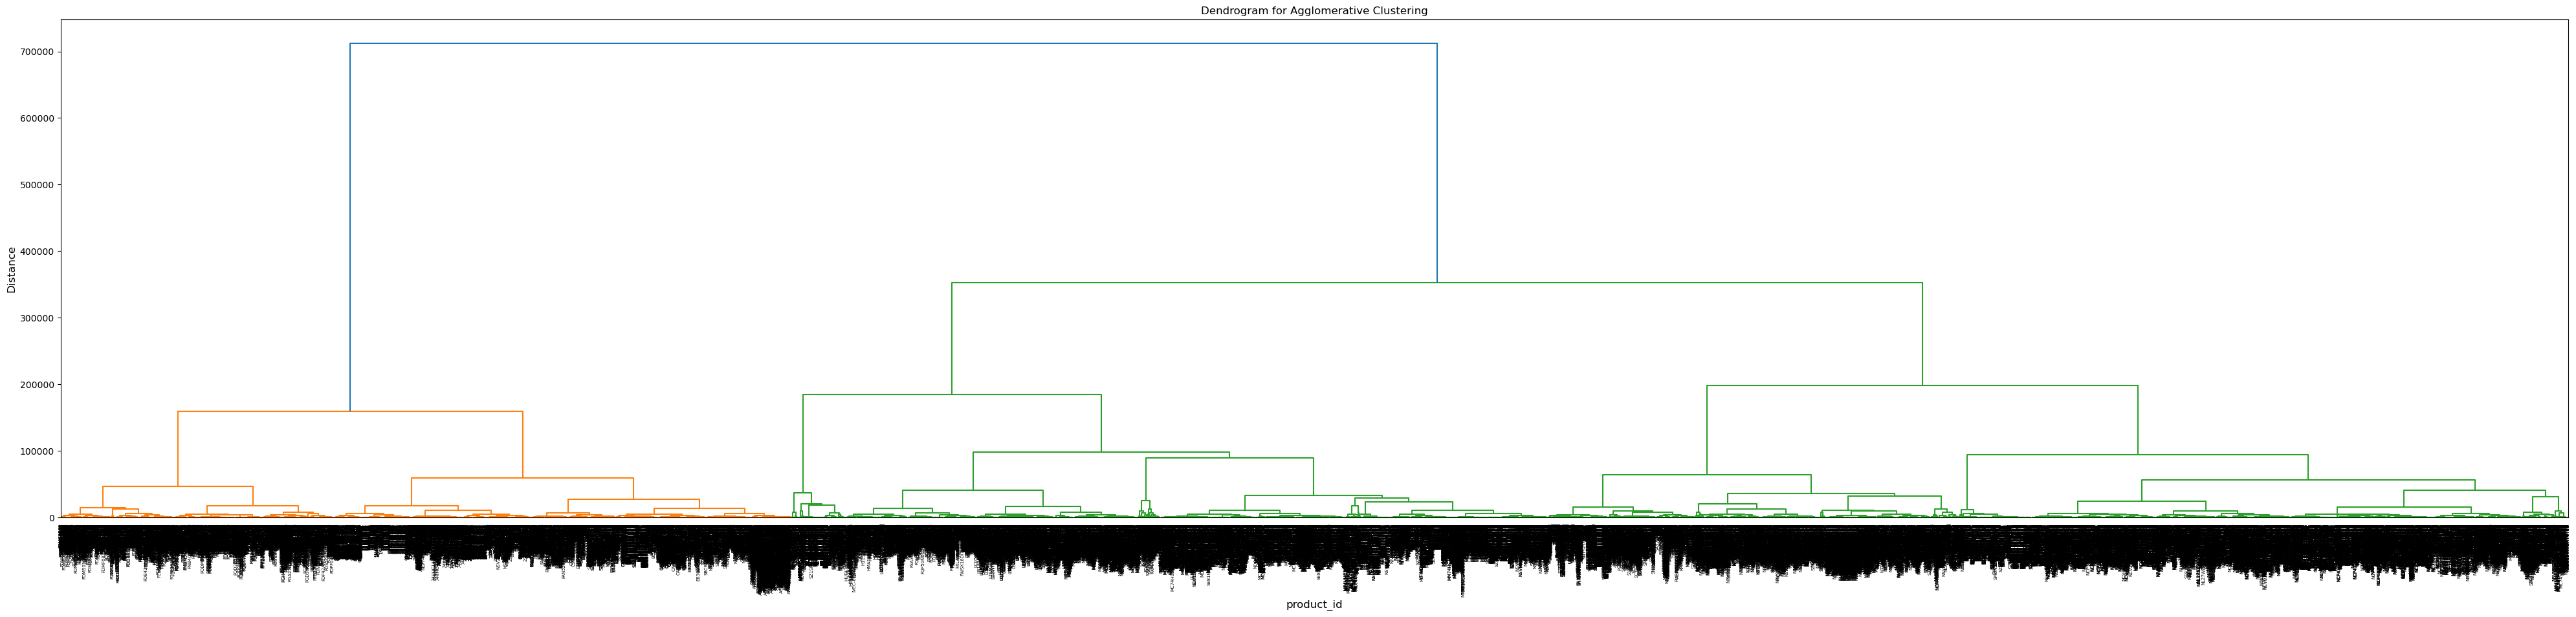

In [7]:
# Combine encoded categorical and standardized numerical features
X = df[['prod_cost_bin', 'web_part', 'ppap', 'group_package', 'price_group', 'price_leader', 'product_level_1', 'product_level_2', 'product_level_3', 'product_level_4', 'division', 'price_strategy', 'avg_pu', 'avg_cu', 'avg_quantity', 'avg_nv', 'avg_list', 'forward_cogs']].values

# Perform agglomerative clustering
linkage_matrix = linkage(X, method='ward')

# Visualize the dendrogram
plt.figure(figsize=(50, 10))
dendrogram(linkage_matrix, labels=df['product_id'].values)
plt.title('Dendrogram for Agglomerative Clustering', fontsize=12)
plt.xlabel('product_id', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()

In [18]:
# Specify the distance threshold (you can adjust this value)
distance_threshold = 10

# Extract flat clusters based on the distance threshold
clusters = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')

# Add the cluster information to the DataFrame
df['cluster_id'] = clusters

# Print the product-cluster mapping
print(df[['product_id', 'cluster_id']])

              product_id  cluster_id
0           LM385BD-1.2G        2106
1              FDMS86520          74
2          NCP3064BMNTXG        4858
3             BC846BWT1G        1505
4          NCP81071ADR2G        4233
...                  ...         ...
17683      2SB815-6-TB-E        1066
17684             RS1GFA        3348
17685         CS9001N14G        1240
17686   E7100-102WD66-WG        1471
17687  NOIX2SN8000B-LTI1        4025

[17688 rows x 2 columns]


In [9]:
df

,product_id,prod_cost_bin,web_part,ppap,group_package,price_group,price_leader,avg_pu,avg_cu,avg_quantity,avg_nv,avg_list,forward_cogs,product_level_1,product_level_2,product_level_3,product_level_4,division,price_strategy,cluster_id
0,LM385BD-1.2G,2,4610,0,262,4443,4504,-0.084569,-0.100770,-0.238526,-0.055557,-0.070013,-0.104993,0,16,130,346,1,6,874
1,FDMS86520,1,2677,0,158,2592,2586,-0.084124,-0.100770,-0.219431,-0.376737,-0.069380,-0.104964,2,11,84,133,7,6,32
2,NCP3064BMNTXG,1,6792,0,42,6504,6474,-0.084515,-0.099675,-0.228624,-0.736806,-0.069604,-0.103524,0,20,170,453,1,6,2260
3,BC846BWT1G,3,1043,0,185,1036,1025,-0.085495,-0.101549,0.124827,-0.360955,-0.070915,-0.105858,2,13,103,227,7,6,612
4,NCP81071ADR2G,1,6973,0,262,6679,6651,-0.084369,-0.100946,-0.202376,-0.609000,-0.069502,-0.105114,0,20,169,448,1,6,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17683,2SB815-6-TB-E,3,511,0,181,511,509,-0.085422,-0.101319,-0.205072,-1.077438,-0.070780,-0.105627,2,13,100,193,7,0,419
17684,RS1GFA,3,9315,0,237,8878,9045,-0.085351,-0.101390,-0.170776,-0.905341,-0.070693,-0.105660,2,19,167,445,7,6,1512
17685,CS9001N14G,0,1417,0,120,1406,1388,-0.082584,-0.098734,-0.235367,1.316121,-0.069074,-0.101999,0,20,170,453,1,0,496
17686,E7100-102WD66-WG,0,1501,0,429,1453,1436,-0.075495,-0.094163,0.161003,-0.009996,-0.061302,-0.097086,0,1,17,21,2,0,597


In [10]:
df.to_csv('results_clustering_OnSemi_v5.csv', sep=',', index=False, encoding='utf-8')